# Testing and examples of band structure calculation
## Low energy hamiltonian of bilayer graphene

## Import modules

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

from pybandstructure import *

## Example parameters for bilayer graphene low energy Hamiltonian

We want to solve the eigenvalue problem
$$ {\cal H} ({\bf k}) u_\nu({\bf k}) = \epsilon_\nu({\bf k})  u_\nu({\bf k})$$
where the effective $2 \times 2$ hamiltonian matrix is given by
$$ {\cal H} ({\bf k}) = \begin{bmatrix} 
\Delta/2 & -\hbar^2(k_x-ik_y)^2/(2m) \\
-\hbar^2(k_x+ik_y)^2/(2m) & -\Delta/2\end{bmatrix} =  -\hbar^2/(2m)[(k_x^2-k_y^2)\sigma_x +2k_xk_y \sigma_y] +\Delta/2 \sigma_z$$

In [2]:
#################### graphene parameters #######################################
#distances in nm, energies in eV
k_cutoff = 1. #nm^-1
m_blg = 0.03  # blg effective mass in units of m_e
delta = 0.0 #gap
const = 1.97**2/0.511 *1e-2 / m_blg #hbar^2/m_blg in eV*nm^2
n_sites = 101

density = 0.
temperature = 0.026
eta = 0.02

In [3]:
#################### Lattice parameters ########################################
#we have no Brillouin zone (the Hamiltonian is valid only in a portion of it)
#we calculate the band structure in a square of side 2 k_cutoff
reciprocal_lattice_basis = 2 * k_cutoff * np.array([[1.,0.],
                                                    [0.,1.]], dtype = float)
#no assumptions on the symmetry point group is the trivial group
point_group = Point_Group.trivial_group(space_dimension = 2)
#defines a fictious square lattice 
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis,
                                    point_group = point_group)
# ad hoc sampling scheme, see plot in the following cell
k_sample = sample.Space_Sample.spherical_sample(basis_vectors = lattice_geometry.reciprocal_lattice_basis, 
                                           denominator = n_sites, cut_off = k_cutoff )

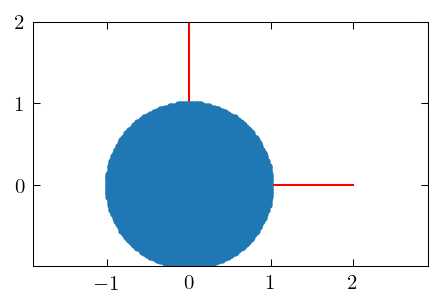

In [4]:
_ = k_sample.plot()

In [5]:
#################### Hamiltonian and overlap matrices ##########################
hamiltonian_matrices = [pauli_matrix('x'), pauli_matrix('y'), pauli_matrix('z')]

hamiltonian_coefficients = [lambda k: - const * (k[0]**2-k[1]**2)/2, 
                            lambda k: - const * (k[0]*k[1]),
                            delta/2]
 
H = Momentum_Conserving_Operator(matrices = hamiltonian_matrices,
                                 coefficients = hamiltonian_coefficients)

#k_x derivative of the hamiltonian
p_x = Momentum_Conserving_Operator(matrices= [pauli_matrix('x'), pauli_matrix('y')],
                                   coefficients = [lambda k: - const * k[0], lambda k: - const * k[1]])
#k_y derivative of the hamiltonian
p_y = Momentum_Conserving_Operator(matrices=[pauli_matrix('x'), pauli_matrix('y')],
                                   coefficients = [lambda k:   const * k[1], lambda k: - const * k[0]])

In [6]:
####################### Output folder ##########################################
output_folder = 'test_output/bilayer_low_energy'
file_name = '/bilayer_low_energy.hdf5'
################################################################################
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
try:
    os.remove(output_folder + file_name)
except:
    pass

band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample,
                                                 hamiltonian = H, 
                                                 momentum_operator= [p_x,p_y],
                                                 degeneracy = 4,
                                                 zero_filling = 1,
                                                 density = density,
                                                 temperature = temperature,
                                                 statistics = 'F')

band_structure.compute_bands()
band_structure.compute_momentum_matrix()
band_structure.save(file_name = output_folder + file_name, band_structure_name = 'band_structure')
blg = Crystal(geometry = lattice_geometry,
                   band_structure = band_structure, 
                   eta = eta)

100%|███████████████████████████████████████████████████████████████████████████| 8021/8021 [00:00<00:00, 11761.02it/s]


## Bands for fixed $k_x$ and $k_y$

Text(0, 0.5, '$\\epsilon_{\\bm k,\\nu}\\,[{\\rm meV}]$')

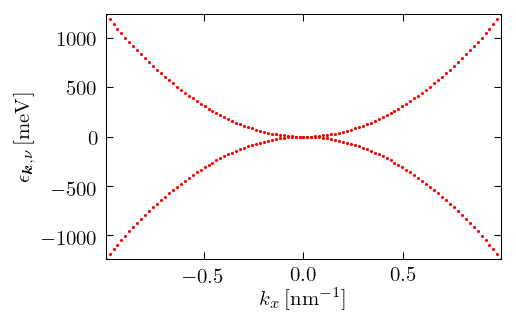

In [7]:
plt.figure()
index = blg.band_structure.k_sample.integer_coords[:,1] == 0
for nu in range(blg.band_structure.energies.shape[0]):
    plt.plot(blg.band_structure.k_sample.coords[index,0],1e3 * blg.band_structure.energies[nu,index],'.',c='r')
plt.xlabel(r'$k_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$\epsilon_{\bm k,\nu}\,[{\rm meV}]$')

Text(0, 0.5, '$\\epsilon_{\\bm k,\\nu}\\,[{\\rm meV}]$')

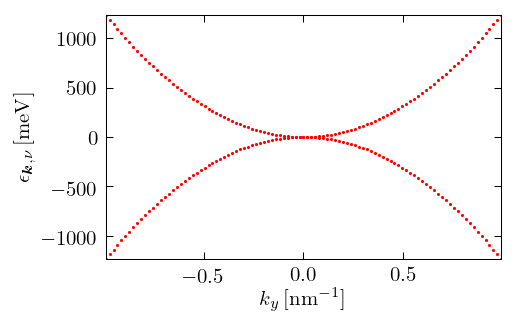

In [8]:
index = blg.band_structure.k_sample.integer_coords[:,0] == 0
for nu in range(blg.band_structure.energies.shape[0]):
    plt.plot(blg.band_structure.k_sample.coords[index,1],1e3 * blg.band_structure.energies[nu,index],'.',c='r')
plt.xlabel(r'$k_y\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$\epsilon_{\bm k,\nu}\,[{\rm meV}]$')

## Density of states

In [9]:
e_vals = np.linspace(np.amin(blg.band_structure.energies), np.amax(blg.band_structure.energies),num=250)
e_lims = e_vals[0], e_vals[-1] #energy limits for the figure
dosvals = blg.dos(e_vals) 

Text(0.5, 0, '$\\epsilon~[{\\rm ev}]$')

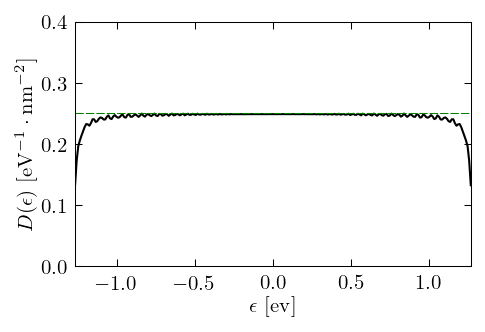

In [10]:
plt.plot(e_vals, dosvals, c='k')
plt.plot(e_vals, np.ones_like(e_vals) * 2/(np.pi * const),'--', c='g', lw=0.5)
plt.ylim(0,0.4)
plt.ylabel(r'$D(\epsilon)~[{\rm eV^{-1}\cdot nm^{-2}}]$')
plt.xlabel(r'$\epsilon~[{\rm ev}]$')

## Change chemical potential and calculate optical conductivity

In [11]:
blg.band_structure.density = 0.01
omega_vals = np.linspace(0,0.6, num = 50)
sigma_vals = blg.local_conductivity(omega_vals)[:,0,0]

..\pybandstructure\band_structure\band_structure.py:581: UserWarning: changing density without changing band structure
  warn("changing density without changing band structure")
..\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


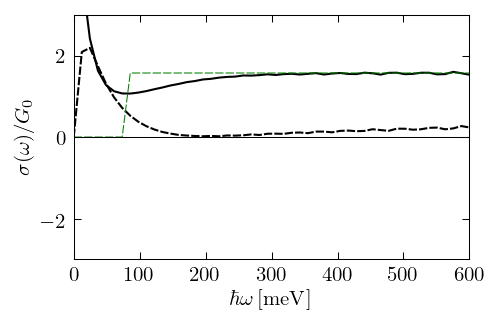

In [12]:
plt.xlabel(r'$\hbar \omega \, [{\rm meV}]$')
plt.ylabel(r'$\sigma(\omega)/G_0$')

plt.plot(1e3*omega_vals,np.real(sigma_vals),c='k')
plt.plot(1e3*omega_vals,np.imag(sigma_vals),'--',c='k')
plt.plot(1e3*omega_vals,np.heaviside(omega_vals-2*abs(blg.band_structure.chemical_potential),0.5)*np.pi/2,'--', c='g', lw=0.5)
plt.plot(1e3*omega_vals,np.zeros_like(omega_vals),'k-',lw=0.5)
plt.ylim(-3,3)
plt.savefig(output_folder +'/conductivity.pdf')